## Compute the location in the Sky (Right Ascension and Declination)
## Where is your telescope pointing?
### Glen Langston -- NSF --  2022 February 5
Over most of the Sky a transit telescope will detect the galactic plane crossing the sky twice a day.   
You'll calculate where you telescope is pointing, and estimate the size of the pointing error

This notebook shows a few features of python processing and plotting.

In [1]:
# Prepare to use some tools for computing your location and coordinates
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
# to compute the Ra, Dec or Galactic Longitude, Latitude your location is needed.
from astropy.coordinates import EarthLocation


In [3]:
# my home address:  Put your address here to see where you are in Earth X,Y,Z
home = EarthLocation.of_address('5477 Potomac Highlands Trail, Arbovale WV USA')
print("%s is where the heart is ..." % (home))

(883348.66971315, -4924998.93189149, 3942078.20708647) m is where the heart is ...


In [4]:
# this works amazingly well!  Some named places also can yield locations
gbt = EarthLocation.of_site('Green Bank Telescope')
# see http://www.greenbankobservatory.org

In [5]:
# There are severeal other ways to set your Earth Latitude, Longitude location
# Google Maps can tell you a location on the map.
tellon = -79.831370676 * u.degree
tellat = 38.422627606 * u.degree
telalt =  814.585 * u.meter
telescope = EarthLocation.from_geodetic( lon=tellon, lat=tellat, height=telalt)

In [6]:
# now we can find out how far my telescope is from the GBT
dx = telescope.x - gbt.x
dy = telescope.y - gbt.y
dz = telescope.z - gbt.z
r2 = dx*dx + dy*dy + dz*dz
r = np.sqrt(r2)
print("Distance to GBT: %s == %10.2f km == %10.2f miles" % (r, r.value/1000.,  r.value/1609.344))

Distance to GBT: 1368.340295882828 m ==       1.37 km ==       0.85 miles


In [7]:
from datetime import datetime, timezone

utc_dt = datetime.now(timezone.utc)

print("Local time {}".format(utc_dt.astimezone().isoformat()))

Local time 2022-02-05T11:34:54.834881-05:00


In [8]:
#Now we can get the time of a current observation
timenow = datetime.now()

In [9]:
# This is your current time:
# years, months, days, hours, minutes, seconds, microseconds
timenow

datetime.datetime(2022, 2, 5, 11, 34, 56, 640056)

In [10]:
# Now set pointing direction of your horn telescope, plus a rough estimate of the pointing error.
az = 0. * u.degree   # due north
alt = 75. * u.degree  # just a little off straight up.

# Estimate how far off you've aligned your telescope (just a guess)
daz = 5. * u.degree   
dalt = -5. * u.degree  # telescope is sagging a bit
# the coordinates can be set without the time and location
# but RA,Dec and Galactic coordinates can not be determined
intended = SkyCoord(alt=alt, az=az, frame="altaz")
# Actual is intended plus delta (error) offsets
actual = SkyCoord(alt=alt+dalt, az=az+daz, frame="altaz")

In [12]:
# Finally, this is where you wanted your telescope to point
# in RA,Dec and Galactic coordinates
nowIntended = SkyCoord(alt=alt, az=az, frame="altaz", location=home, obstime=timenow)
radecIntended = nowIntended.transform_to( frame="icrs")
# now we can find the true location on the sky, which is intended plus offset
nowActual = SkyCoord(alt=alt+dalt, az=az+daz, frame="altaz", location=home, obstime=timenow)
radecActual = nowActual.transform_to( frame="icrs")


In [13]:
# print intended, actual and offsets in absolute coordinates
print("Intended:", radecIntended.ra, radecIntended.dec)
print("Actual:  ", radecActual.ra, radecActual.dec)
print("Offset:  ", radecIntended.ra - radecActual.ra, radecIntended.dec - radecActual.dec)

Intended: 229d20m54.6183128s 53d30m20.48740197s
Actual:   232d38m02.94328853s 58d23m20.6676343s
Offset:   -3d17m08.32497573s -4d53m00.18023233s


## Congratulations! You've converted your telescope pointing direction to Sky coordinates.
### You've also roughly estimated how amount of miss-pointing your telescope effects the actual location of your observations

### Next show the current location your telescope is pointing, compared to the Galactic plane location
First read in the coordinates of the Galactic Plane you calculatd in a previous exercise.

In [19]:
# now read in the table of galactic plan coordinates from another excercise

def read4( file): 
    f = open(file, "r")
    lines = f.readlines()
    f.close()
    decs = []
    ra1s = []
    ra2s = []
    deltas = []
    
    # next convert the ascii lines to numpy arrays
    for aline in lines:
        aline = aline.strip()
        # if a comment line just print and go to next line
        if aline[0] == '#':
            print(aline)
        else:
            parts = aline.split()
            if len(parts) == 4:
                decs.append(float(parts[0]))
                ra1s.append(float(parts[1]))
                ra2s.append(float(parts[2]))
                deltas.append(float(parts[3]))
        # end for all linesin the file
    f.close()
    # convert from lists to arrays
    decs = np.asarray( decs)
    ra1s = np.asarray( ra1s)
    ra2s = np.asarray( ra2s)
    deltas = np.asarray( deltas)
    # end of read 4
    return decs, ra1s, ra2s, deltas


In [20]:
file = "GalacticPlaneCrossingOffsets.txt"
# now use the procedure just defined to read the file

decs, ra1s, ra2s, deltas = read4( file)
ndata = len(ra1s)
# For the plot we want RAs to range from 0 to 360
for iii in range(ndata):
    if ra1s[iii] < 0:
        ra1s[iii] = ra1s[iii] + 360.
    if ra2s[iii] < 0:
        ra2s[iii] = ra2s[iii] + 360.

print("Read in %d data lines:  Declination range: %7.2f to %7.2f" % (ndata, decs.min(), decs.max()))

# Table of Angular offsets between Transit Crossings of the Galactic Plane
# Glen Langston -- NSF -- glangsto@nsf.gov
# Dec    RA1     RA2   Delta RA
# (d)    (d)     (d)     (d)
Read in 124 data lines:  Declination range:  -62.00 to   61.00


### Now plot the Milky Way Galactic Plane and your current telescope pointing.

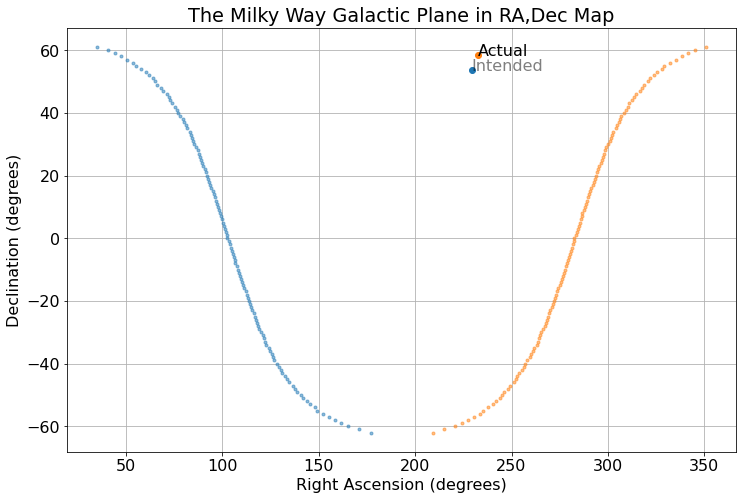

In [23]:
# next plot these coordinates 
import matplotlib.pyplot as plt
# make the font a little bigger.
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(12,6.2))
ax = fig.add_subplot(111)
plt.subplot(111)
# you can use different projections for x,y plots
#plt.subplot(111, projection="Aitoff")
#NOTE if you use the AITOFF projection you must enter Angles in Radians
#plt.title("Aitoff projection of the Milky Way Galactic Plane in RA,Dec Map")
plt.title("The Milky Way Galactic Plane in RA,Dec Map")
plt.grid(True)
#plt.plot(ra_rad, dec_rad, 'o', markersize=2, alpha=0.3)
plt.plot(ra1s, decs, 'o', markersize=3, alpha=0.5)
plt.plot(ra2s, decs, 'o', markersize=3, alpha=0.5)
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.xlabel("Right Ascension (degrees)")
plt.ylabel("Declination (degrees)")
# now add intended coordinate and actual coordinates
ra = radecIntended.ra.value
dec = radecIntended.dec.value
ax.annotate("Intended", xy=[ra, dec], textcoords='data', alpha=.5)
plt.scatter( radecIntended.ra, radecIntended.dec,label="Intended")
ra = radecActual.ra.value
dec = radecActual.dec.value
ax.annotate("Actual", xy=[ra, dec], textcoords='data')
plt.scatter( radecActual.ra, radecActual.dec, label="Actual")
plt.show()

# Congratulations! 
## You know know where the Milky Way is compared to your observations